In [2]:
import pywt
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from biosppy.signals import ecg

from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from waveform_processor import ABPWaveformProcessor

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
storeA=pd.HDFStore('abp_data/ABP_A.hd5')
storeB=pd.HDFStore('abp_data/ABP_B.hd5')
storeC=pd.HDFStore('abp_data/ABP_C.hd5')

wavesA=storeA.select('Waveforms')
wavesB=storeB.select('Waveforms')
wavesC=storeC.select('Waveforms')

DATA_TIME_CONST = 0.004166747

wavesA.iloc[0:8]

,AR1,I,II,III,V,SPO2
2017-07-06 12:00:00.000000080,73.4,0.039,0.181,0.142,0.181,34.32
2017-07-06 12:00:00.004166747,80.4,0.054,0.210,0.161,0.195,34.32
2017-07-06 12:00:00.008333414,88.2,0.063,0.244,0.173,0.210,34.32
2017-07-06 12:00:00.012500081,96.2,0.081,0.278,0.193,0.224,34.32
2017-07-06 12:00:00.016666748,103.0,0.093,0.303,0.207,0.244,34.32
2017-07-06 12:00:00.020833415,110.0,0.105,0.329,0.220,0.259,34.32
2017-07-06 12:00:00.025000082,114.4,0.117,0.354,0.232,0.271,34.32
2017-07-06 12:00:00.029166749,118.8,0.132,0.376,0.239,0.283,34.32


In [5]:
# detail_coeffs_list = [["cA5", "cD5"],["cA4", "cD4"],["cA3", "cD3"],["cA2", "cD2"],["cA1", "cD1"]]

# print()
# print(math.floor(len(wavesA) / math.ceil(13.5 / DATA_TIME_CONST)))

def generateSWTCoeffs(waveform, level=5):
#     time_units = math.ceil(window / DATA_TIME_CONST)
#     abp_signal_swt = wavesA.iloc[0:3200]['AR1']
    db4 = pywt.Wavelet('db4')
#     print(pywt.swt(abp_signal_swt, db4, level=5))
    return pywt.swt(waveform, db4, level=level)
    #return (cA5a, cD5a), (cA4a, cD4a), (cA3a, cD3a), (cA2a, cD2a), (cA1a, cD1a) = pywt.swt(abp__signal_swt, db4, level=5)
    
def calcEnergy(coeff):
    return np.sqrt(np.sum(np.array(coeff ** 2)) / len(coeff))

In [6]:
def segmenter(level=5, window_multiplier=1):
    section_size = math.ceil(13.5 / DATA_TIME_CONST)
    section_size = int((100*2**level / 4)) * window_multiplier
    return np.arange(0, len(wavesA), section_size)

In [7]:
def listCreator(levels):
    new_list = []
    for i in range(levels, 0, -1):
        new_list.append(["cA{0}".format(i),"cD{0}".format(i)])
    return new_list

listCreator(6)

[['cA6', 'cD6'],
 ['cA5', 'cD5'],
 ['cA4', 'cD4'],
 ['cA3', 'cD3'],
 ['cA2', 'cD2'],
 ['cA1', 'cD1']]

In [8]:
def processWaveform(waveform, level, window_multiplier):
    energy = {}

    for label in listCreator(level):
        energy[label[0]] = []
        energy[label[1]] = []

    segments = segmenter(level, window_multiplier)

    for i in range(1, len(segments)):
        #signal1 = waveform.head(3200)['AR1']
        signal = waveform.iloc[segments[i-1]:segments[i]]['AR1']

        for coeff, label in zip(generateSWTCoeffs(signal, level), listCreator(level)):
            for single_coeff, single_label in zip(coeff, label):
                nrgCoeff = calcEnergy(single_coeff)
                energy[single_label].append(nrgCoeff)

    return pd.DataFrame(data=energy)

print(processWaveform(wavesA, 5, 1))

           cA1         cA2         cA3         cA4         cA5       cD1  \
0   105.861738  149.710211  211.671511  298.710771  419.280458  0.170124   
1   101.241853  143.164561  202.372722  285.483363  400.607149  1.115184   
2   100.223386  141.721902  200.345889  282.687707  396.546182  1.197331   
3    95.395780  134.908242  190.747571  269.169308  377.211207  0.374473   
4    93.385411  132.063195  186.726047  263.561696  369.818292  0.568694   
5    95.197163  134.628611  190.359492  268.664601  376.766208  0.143535   
6    94.229575  133.250640  188.385128  265.884836  373.127446  0.938555   
7    97.701972  138.165969  195.345445  275.694626  386.813515  0.678833   
8    98.960649  139.949915  197.876845  279.241943  391.531696  0.355638   
9    99.811699  141.152627  199.579407  281.714594  395.578594  0.463468   
10  102.864485  145.471698  205.684041  290.263495  407.320940  0.170432   
11  101.588050  143.666485  203.135732  286.733652  402.701153  0.198004   
12  100.4115

In [26]:
waveform_processor = ABPWaveformProcessor()

colors = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

p1 = figure(plot_width=600, plot_height=300, title="Detail Number vs Energy Coefficients")
p2 = figure(plot_width=600, plot_height=300, title="Average Number vs Energy Coefficients with Jitter")

df = waveform_processor.processWaveform(wavesA, 6, 1)

for i, coeffs in enumerate(df):
    for value in df[coeffs]:
        y = value
        color = colors[i % len(colors)]
        
        if "cD" in coeffs: 
            p1.circle(x=i, y=y, color=color)
        else:
            p2.circle(x=i, y=y, color=color)
            #{'value': i, 'transform': Jitter(width=1)}

# output_file("jitter.html")
print(column(p1,p2).references)
show(column(p1,p2), notebook_handle=True)

<bound method Model.references of Column(id='a538914d-a66a-4eec-8682-94c2c1dbb1e0', ...)>


In [23]:
waveform_processor = ABPWaveformProcessor()

colors = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

p1 = figure(plot_width=600, plot_height=300, title="Detail Number vs Energy Coefficients")
p2 = figure(plot_width=600, plot_height=300, title="Average Number vs Energy Coefficients with Jitter")

df = waveform_processor.processWaveform(wavesB, 6, 1)

for i, coeffs in enumerate(df):
    for value in df[coeffs]:
        y = value
        color = colors[i % len(colors)]
        
        if "cD" in coeffs: 
            p1.circle(x=i, y=y, color=color)
        else:
            p2.circle(x=i, y=y, color=color)
            #{'value': i, 'transform': Jitter(width=1)}

# output_file("jitter.html")

show(column(p1,p2), notebook_handle=True)

In [11]:
waveform_processor = ABPWaveformProcessor()

colors = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

p1 = figure(plot_width=600, plot_height=300, title="Detail Number vs Energy Coefficients")
p2 = figure(plot_width=600, plot_height=300, title="Average Number vs Energy Coefficients with Jitter")

df = waveform_processor.processWaveform(wavesC, 6, 1)

for i, coeffs in enumerate(df):
    for value in df[coeffs]:
        y = value
        color = colors[i % len(colors)]
        
        if "cD" in coeffs: 
            p1.circle(x=i, y=y, color=color)
        else:
            p2.circle(x=i, y=y, color=color)
            #{'value': i, 'transform': Jitter(width=1)}

# output_file("jitter.html")

show(column(p1,p2), notebook_handle=True)

In [12]:
waveform_processor = ABPWaveformProcessor()

level = 7
window_size = 1

df_A = waveform_processor.processWaveform(wavesA, level, window_size)
df_B = waveform_processor.processWaveform(wavesB, level, window_size)
df_C = waveform_processor.processWaveform(wavesC, level, window_size)

colors = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

p1 = figure(plot_width=600, plot_height=300, title="Detail Number vs Energy Coefficients")
p2 = figure(plot_width=600, plot_height=300, title="Average Number vs Energy Coefficients")

for color, data in zip(["red", "goldenrod", "skyblue"], [df_A, df_B, df_C]):
    data = data.head(5)
    print(data)
    for i, coeffs in enumerate(data):
#         print(coeffs)
        for value in data[coeffs]:
#             print(value)
            y = value
            #color = colors[i % len(colors)]

            if "cD" in coeffs: 
                p1.circle(x=i, y=y, color=color)
            else:
                p2.circle(x=i, y=y, color=color)
                #{'value': i, 'transform': Jitter(width=1)}

# output_file("jitter.html")

output_notebook()

show(column(p1,p2), notebook_handle=True)

          cA1         cA2         cA3         cA4         cA5         cA6  \
0  100.752676  142.484956  201.459640  284.290463  398.923128  556.986799   
1   95.144252  134.553523  190.253801  268.537826  376.672884  525.411728   
2  100.818034  142.577592  201.595441  284.529431  399.336816  557.863368   
3   97.129984  137.360669  194.215564  274.085009  384.244733  536.398330   

          cA7       cD1       cD2       cD3        cD4        cD5        cD6  \
0  780.959498  0.188553  0.490554  4.235399  18.732478  50.024722  89.694089   
1  736.581083  0.220339  0.454508  3.576686  16.746746  48.401096  87.792020   
2  782.720567  0.176797  0.426808  4.002206  18.012414  49.437850  87.910460   
3  752.346374  0.388746  0.717021  4.027616  17.798269  51.001661  86.976211   

          cD7  
0  102.814645  
1   97.792008  
2   98.851339  
3   97.063226  
         cA1         cA2         cA3         cA4         cA5         cA6  \
0  97.185008  137.439925  194.354428  274.391162  383.471

Loading BokehJS ...

12


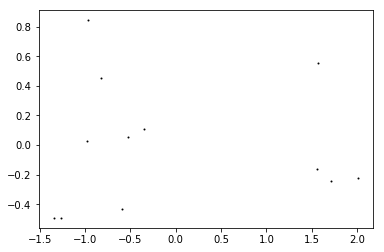

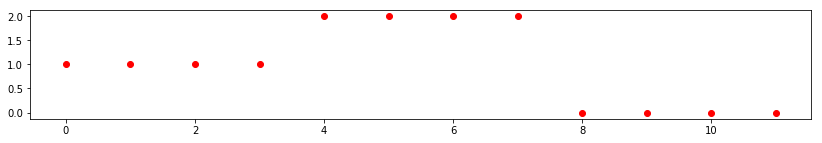

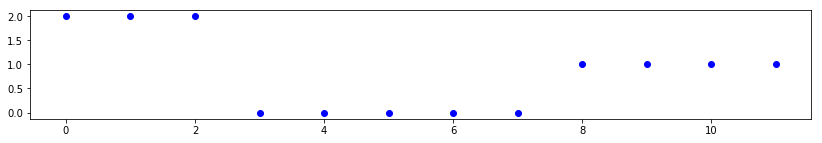

In [13]:
df_whole = pd.concat([df_A, df_B, df_C])

df_whole.drop(['cA1', 'cA2', 'cA3', 'cA4', 'cA5', 'cA6', 'cA7', 'cD1', 'cD2', 'cD3', 'cD4'], axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
abp_train_minmax = min_max_scaler.fit_transform(df_whole)

# print(pd.DataFrame(abp_train_minmax))

n_samples, n_features = abp_train_minmax.shape #1622, 10
n_digits = 3
n_targets = ['0', '1', '2']

cluster_data = KMeans(n_clusters=n_digits).fit_predict(abp_train_minmax)

reduced_data = PCA(n_components=2).fit_transform(abp_train_minmax)

pca_kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10).fit_predict(reduced_data)

print(len(pca_kmeans))

plt.figure(1)
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

plt.figure(2, figsize=(14, 2))
plt.scatter(np.arange(0,12), cluster_data, color='red')

plt.figure(3, figsize=(14, 2))
plt.scatter(np.arange(0,12), pca_kmeans, color='blue')

plt.show()

In [24]:
p = figure(plot_width=900, plot_height=400)

# add a circle renderer with a size, color, and alpha
p.circle(np.arange(0, len(df_whole)), df_whole["cD7"], size=5, color="olive", alpha=0.5)
p.circle(np.arange(0, len(df_whole)), df_whole["cD6"], size=5, color="red", alpha=0.5)
p.circle(np.arange(0, len(df_whole)), df_whole["cD5"], size=5, color="navy", alpha=0.5)

output_notebook()
# show the results
show(p, notebook_handle=True)

Loading BokehJS ...